# Bending of the lithosphere under seamounts

**Goal:** Implement the finite-difference solution to the 1D flexure equation and compare it's predictions against observations of gravity disturbances and bathymetry.

With the appropriate boundary condition, we can use the 1D flexure equation to model the bending of the oceanic lithosphere under the load of a seamount or island chain. **Our assumption is that the plate is perfectly elastic and structures are infinite perpendicular to the profile.** 

<img style="width: 500px; margin: 10px auto;" src="https://github.com/leouieda/lithosphere/raw/be03c3400f4850de815a71b8536874ee2af4308b/lectures/assets/flexure-seamount.svg">
<p style="text-align: left; width: 500px; max-width: 100%; margin: 30px auto;">
Figure caption: Sketch of the elastic plate flexure for a load $q(x)$.
</p>

## Governing equations

The equation describing the deflection ($w$) of an elastic plate subject to a vertical load is:

$$ D\dfrac{\partial^4 w}{\partial x^4} = q(x) - g (\rho_m - \rho_w) w $$

in which $x$ is the position along the profile, $D$ is the flexural rigidity of the plate, $rho_w$ and $rho_m$ are the water and mantle densities, $g$ is gravity (for these purposes, assume $9.8\ m/s^2$), and $q(x)$ is a force density applied by the load on the plate (the weight of the topography). The term $g (\rho_m - \rho_w) w$ is the restoring hydrostatic force (buoyancy) from replacing mantle material at depth with water on top because of the flexure.

The **flexural rigidity** $D$ can be described in terms of the plate's elastic parameters:

$$ D = \dfrac{E T_e^3}{12(1 - \nu^2)} $$

where $E$ is [Young's modulus](https://en.wikipedia.org/wiki/Young's_modulus), $\nu$ is [Poisson's ratio](https://en.wikipedia.org/wiki/Poisson's_ratio), and $T_e$ is the *effective elastic thickness*.

The **load force per unit area** $q(x)$ is the weight of the load applied on the lithosphere. For a load of height $h$ and density $\rho_c$, the weight per unit area is (negative because the force is applied downwards):

$$ q(x) = -g \rho_c h(x) $$

## Boundary conditions

If we assume that the load is applied somewhere in the middle of the plate, we can consider the boundaries as stable lithosphere under no load. In that case, we don't expect to see any deflection at the boundaries. We can also impose that the first derivative of deflection is zero at the boundaries (the plate approaches the boundaries horizontally, not at an angle). This leads to the boundary conditions:

$$
\begin{align}
    w(x=0) &= 0 \\
    w(x=x_{max}) &= 0 \\
    \dfrac{\partial w}{\partial x}(x=0) &= 0 \\
    \dfrac{\partial w}{\partial x}(x=x_{max}) &= 0
\end{align}
$$

## The data

**Download** (if you haven't already): [global-geophysical-data.nc](https://github.com/leouieda/lithosphere/raw/main/data/global-geophysical-data.nc) (place it in the **same folder** as this notebook)

The data grids are stored in a [netCDF](https://en.wikipedia.org/wiki/NetCDF) file, which is a very common standard for storing and distributing gridded data. It's used throughout the Earth, ocean, and climate sciences and can be read an manipulated with most software platforms. It contains global grids of gravity, topography, and heat flow. All grids were interpolated onto the same resolution of 0.2 degrees (a compromise between resolution and size of the file) so that we can easily compare and use all of the data together.

* **Gravity**: generated from the [EIGEN-6C4 spherical harmonic model](https://doi.org/10.5880/icgem.2015.1) through the [ICGEM webservice](http://icgem.gfz-potsdam.de/home). It includes two grids: the gravity disturbance calculated with the WGS84 ellipsoid and the Bouguer gravity disturbance calculated using a topography density of 2670 kg/m³. The data for both grids was generated on top of the Earth's surface (the water surface in the oceans and topography on land).
* **Topography and bathymetry**: a downsampled version of [ETOPO1](https://doi.org/10.7289/V5C8276M) and includes a version smoothed using a Gaussian filter with 1 degree width (~100 km).
* **Heat flow**: an upsampled version of the compilation by [Lucazeau (2019)](https://doi.org/10.1029/2019GC008389) (originally 0.5 degree resolution).
* **Lithosphere age (oceanic)**: a downsampled version of the grid by [Müller et al. (2008)](https://doi.org/10.1029/2007GC001743) (originally 6 arc-minutes).

## Import the required libraries

Load the required software to load the data, make maps, and perform calculations.

In [1]:
# For arrays and linear algebra
import numpy as np
# To make figures and maps
import matplotlib.pyplot as plt
# To load and manipulate grids
import xarray as xr
# Import our own module (lithosphere.py)
import lithosphere

## Load the data grids

Once again, we'll use xarray to load the data from the netCDF file.

In [2]:
data = xr.load_dataset("global-geophysical-data.nc")
data

<xarray.Dataset>
Dimensions:              (latitude: 901, longitude: 1800)
Coordinates:
  * latitude             (latitude) float32 -90.0 -89.8 -89.6 ... 89.6 89.8 90.0
  * longitude            (longitude) float32 -180.0 -179.8 ... 179.6 179.8
    height               (latitude, longitude) float32 2.716e+03 ... 15.47
Data variables:
    gravity_disturbance  (latitude, longitude) float32 -27.21 -27.21 ... 24.71
    gravity_bouguer      (latitude, longitude) float32 -331.2 -331.2 ... 312.6
    topography_smoothed  (latitude, longitude) float32 2.796e+03 ... -3.56e+03
    topography           (latitude, longitude) float32 2.716e+03 ... -4.213e+03
    heat_flow            (latitude, longitude) float32 75.2 75.2 ... 84.7 84.7
    lithosphere_age      (latitude, longitude) float32 nan nan ... 55.46 55.46

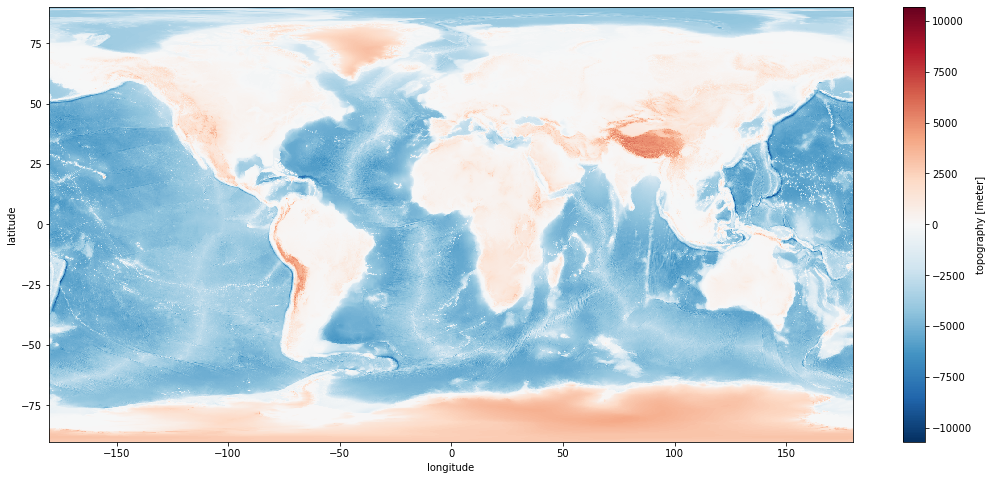

In [3]:
data.topography.plot(figsize=(18, 8))

## Extracting a profile 

Once again, we'll extract a profile from our data grids. This time, we will use the function that we placed in `lithosphere.py` so we don't have to copy the code into this notebook.

First, let's slice a region in the North Atlantic where there are some nice seamounts.

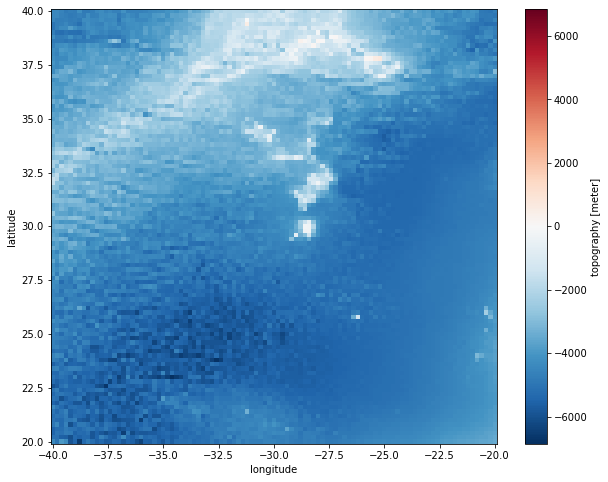

In [4]:
seamount_data = data.sel(longitude=slice(-40, -20), latitude=slice(20, 40))
seamount_data.topography.plot(figsize=(10, 8))

Now extract a profile that cuts across the seamount chain.

In [5]:
lon, lat = lithosphere.profile_points(start=(-33, 31), end=(-24, 31), npoints=100)
profile = seamount_data.interp(longitude=lon, latitude=lat)

Plot the location of the profile.

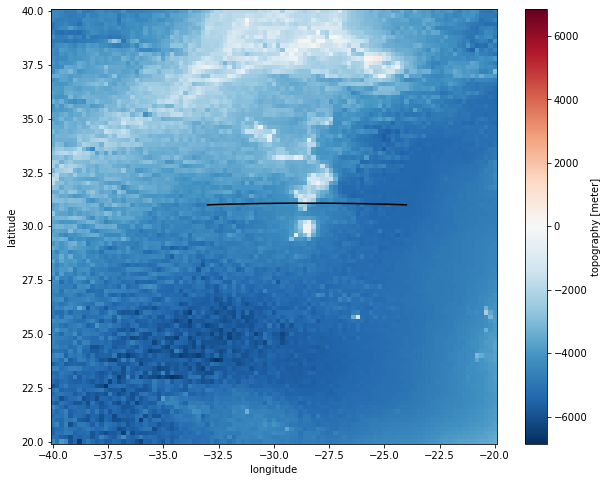

In [6]:
seamount_data.topography.plot(figsize=(10, 8))
plt.plot(profile.longitude, profile.latitude, "k")

And the profile topography and gravity disturbance data.

(0.0, 857.5795528272889)

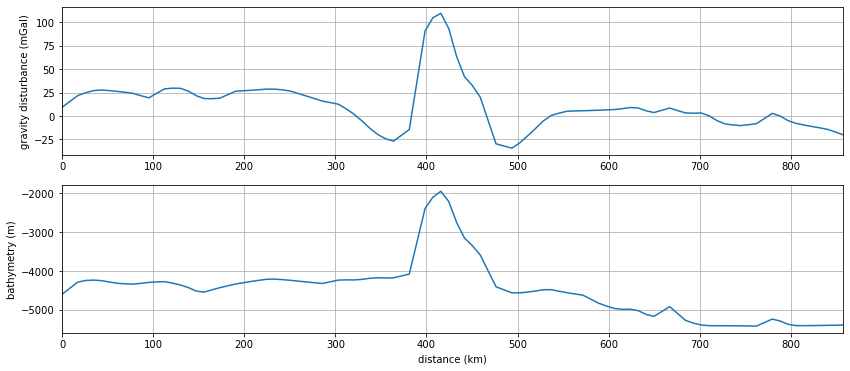

In [7]:
plt.figure(figsize=(14, 6))
ax = plt.subplot(2, 1, 1)
plt.plot(profile.distance, profile.gravity_disturbance)
plt.grid()
plt.ylabel("gravity disturbance (mGal)")
plt.xlim(profile.distance.min(), profile.distance.max())
plt.subplot(2, 1, 2)
plt.plot(profile.distance, profile.topography)
plt.grid()
plt.ylabel("bathymetry (m)")
plt.xlabel("distance (km)")
plt.xlim(profile.distance.min(), profile.distance.max())

We will need the height of the seamount load above the background bathymetry for our modeling. So let's see if we can calculate that.

In [8]:
reference_bathymetry = -4500
seamount_mask = np.logical_and(profile.distance > 380, profile.distance < 480)
load_bathymetry = xr.where(seamount_mask, profile.topography, reference_bathymetry)

(0.0, 857.5795528272889)

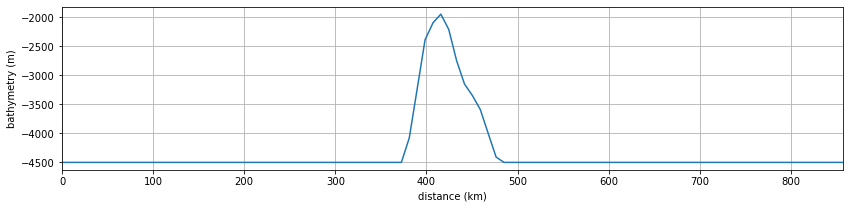

In [9]:
plt.figure(figsize=(14, 3))
plt.plot(profile.distance, load_bathymetry)
plt.grid()
plt.ylabel("bathymetry (m)")
plt.xlabel("distance (km)")
plt.xlim(profile.distance.min(), profile.distance.max())

## Solving the flexure equation by finite-differences

The finite-difference solution to the flexure equation is the solution (the $w_i$ terms) to the equation system:

$$
\begin{align}
  D w_{4} - 4 D w_{3} + \left[6D + \Delta x^4 (\rho_m - \rho_w) g\right] w_2 - 4 D w_{1} + D w_{0} &= \Delta x^4 q_2  \\ 
  D w_{5} - 4 D w_{4} + \left[6D + \Delta x^4 (\rho_m - \rho_w) g\right] w_3 - 4 D w_{2} + D w_{1} &= \Delta x^4 q_3  \\ 
  \vdots & \\
  D w_{N-1} - 4 D w_{N-2} + \left[6D + \Delta x^4 (\rho_m - \rho_w) g\right] w_{N-3} - 4 D w_{N-4} + D w_{N-5} &= \Delta x^4 q_{N-3} \\
  w_0 &= 0  \\
  w_{N-1} &= 0  \\
  w_1 - w_0 &= 0  \\
  w_{N-1} - w_{N-2} &= 0 
\end{align}
$$

Here, the continuous $w$ and $q$ have been discretized into $N$ values with a spacing of $\Delta x$ between them. 

Another way of writing this equation system is using a matrix notation:

$$
\underbrace{
\begin{bmatrix}
  D  & -4D & \left[6D + \Delta x^4 (\rho_m - \rho_w) g\right] & -4D & D & 0 & 0 & \ldots & 0 & 0 \\ 
  0 & D  & -4D & \left[6D + \Delta x^4 (\rho_m - \rho_w) g\right] & -4D & D & 0 & \ldots & 0 & 0 \\ 
  \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots  \\
  1 & 0 & 0 & 0 & 0 & 0 & 0 & \ldots & 0 & 0  \\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & \ldots & 0 & 1  \\
  -1 & 1 & 0 & 0 & 0 & 0 & 0 & \ldots & 0 & 0  \\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & \ldots & -1 & 1
 \end{bmatrix}
}_{\bar{\bar{A}}}
\underbrace{
\begin{bmatrix}
  w_0 \\
  w_1 \\
  w_2 \\
  w_3 \\
  w_4 \\
  w_5 \\
  w_6 \\
  \vdots \\
  w_{N-1} 
 \end{bmatrix}
}_{\bar{w}}
 =
\underbrace{
\begin{bmatrix}
  \Delta x^4 q_2 \\
  \Delta x^4 q_3 \\
  \vdots \\
  0\\
  0\\
  0\\
  0
 \end{bmatrix}
}_{\bar{b}}
$$

$$
\bar{\bar{A}} \bar{w} = \bar{b}
$$

We'll need to figure out a way to build the $\bar{\bar{A}}$ matrix and $\bar{b}$ vector. Once we have those, we can the deflection $\bar{w}$ using `numpy.linalg.solve`.

Let's write write a function that builds the matrix and vector and then solves the system.

In [10]:
def seamount_flexure(load_height, deltax, flexural_rigidity, density_crust, density_water, density_mantle):
    """
    Calculate the deflection caused by the given load.
    
    The load should be an array with the same number of elements as the
    desired deflection. 
    
    deltax is the spacing between consecutive nodes.
    
    All inputs and outputs are in SI units.
    """
    N = load_height.size
    deltax4 = deltax ** 4    
    gravity = 9.8
    density_contrast = density_mantle - density_water
    # Calculate the load force density based on the height of the seamount
    # (not the bathymetry!)
    load = -gravity * density_crust * load_height    
    # Build the finite-difference part of A
    A = np.zeros((N, N))
    for i in range(0, N - 4):
        A[i, i] = flexural_rigidity
        A[i, i + 1] = -4 * flexural_rigidity
        A[i, i + 2] = 6 * flexural_rigidity + deltax4 * (density_contrast * gravity)
        A[i, i + 3] = -4 * flexural_rigidity
        A[i, i + 4] = flexural_rigidity
    # Now fill in the boundary condition
    A[N - 4, 0] = 1
    A[N - 3, -1] = 1
    A[N - 2, 0] = -1
    A[N - 2, 1] = 1
    A[N - 1, -2] = -1
    A[N - 1, -1] = 1
    # Build the b vector
    b = np.zeros(N)
    for i in range(0, N - 4):
        b[i] = deltax4 * load[i + 2]
    # Solve for w
    deflection = np.linalg.solve(A, b)
    return deflection

We'll assume that the flexural parameters of the lithosphere are:

* Poisson's ratio: $\nu = 0.25$
* Young's modulus: $E = 70 \times 10^9\ \frac{kg}{s^2 m}$

We'll vary the effective elastic thickness $T_e$ as needed but it will probably be around 20-40 km. 
With these, we can calculate the flexural rigidity $D$.

In [11]:
def flexural_rigidity(poissons_ratio, youngs_modulus, elastic_thickness):
    """
    Calculate the flexural rigidity D.
    
    All inputs and outputs in SI.
    """
    rigidity = youngs_modulus * elastic_thickness ** 3 / (
        12 * (1 - poissons_ratio ** 2)
    )
    return rigidity

Now we can solve for $w$.

In [12]:
deflection = seamount_flexure(
    load_height=load_bathymetry - reference_bathymetry, 
    deltax=(profile.distance[1] - profile.distance[0]) * 1000, 
    flexural_rigidity=flexural_rigidity(poissons_ratio=0.25, youngs_modulus=70e9, elastic_thickness=20e3), 
    density_crust=2600,
    density_mantle=3300,
    density_water=1000,
)

(0.0, 857.5795528272889)

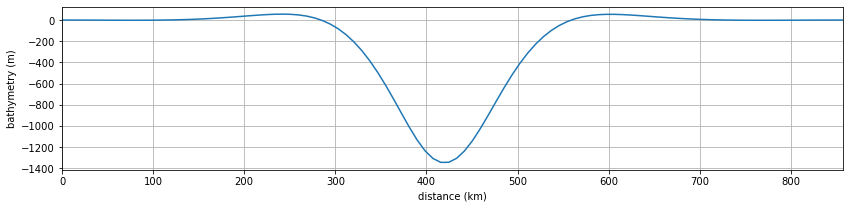

In [13]:
plt.figure(figsize=(14, 3))
plt.plot(profile.distance, deflection)
plt.grid()
plt.ylabel("bathymetry (m)")
plt.xlabel("distance (km)")
plt.xlim(profile.distance.min(), profile.distance.max())

## Predicting gravity

We can also predict the observed gravity disturbances from the calculated deflection. To do so, we derive the density anomalies caused by the downward deflection of the oceanic crust. The figure below illustrate a conceptual model of the density anomalies causing the observed data.

<img style="width: 500px; margin: 10px auto;" src="https://github.com/leouieda/lithosphere/raw/be03c3400f4850de815a71b8536874ee2af4308b/lectures/assets/disturbance-flexure-model.svg">
<p style="text-align: left; width: 500px; max-width: 100%; margin: 30px auto;">
Figure caption: Model of the density anomalies causing the observed gravity disturbance due to the flexure and the presence of the seamount.
</p>

The gravitational effect of these density anomalies can be estimated using a **Bouguer plate approximation** by carefully assigning the correct density contrasts to each part of the model: 

$$ g \approx 2 \pi G \Delta\rho |w| $$

To make things easier, we can split the effect into 3 parts which can be added together to produce the final result:

1. The seamount
2. The deflection at the surface
3. The deflection at the Moho

Let's write a function that calculates the predicted gravity for our seamount flexure.

In [14]:
def gravity_seamount(
    deflection, 
    load_height, 
    density_crust, 
    density_mantle, 
    density_water,
):
    """
    Model the gravity disturbance caused by a deflection of the lithosphere.    
    Inputs are in SI units and outputs are in mGal.
    """
    # The gravity of the seamount
    seamount = 2 * np.pi * lithosphere.GRAVITATIONAL_CONSTANT_SI * (density_crust - density_water) * load_height
    # The gravity of the surface deflection
    density_surface = xr.where(deflection > 0, density_crust - density_water, density_water - density_crust)
    surface = 2 * np.pi * lithosphere.GRAVITATIONAL_CONSTANT_SI * density_surface * np.abs(deflection)
    # The gravity of the Moho deflection
    density_moho = xr.where(deflection > 0, density_mantle - density_crust, density_crust - density_mantle)
    moho = 2 * np.pi * lithosphere.GRAVITATIONAL_CONSTANT_SI * density_moho * np.abs(deflection)
    # Combine and convert to mGal
    result = 1e5 * (seamount + surface + moho)
    return result

Now we can predict the gravity disturbance and plot it agaisnt our observed data.

In [15]:
predicted_gravity = gravity_seamount(
    deflection, 
    load_height=load_bathymetry - reference_bathymetry, 
    density_crust=2600, 
    density_water=1000, 
    density_mantle=3300,
)

(0.0, 857.5795528272889)

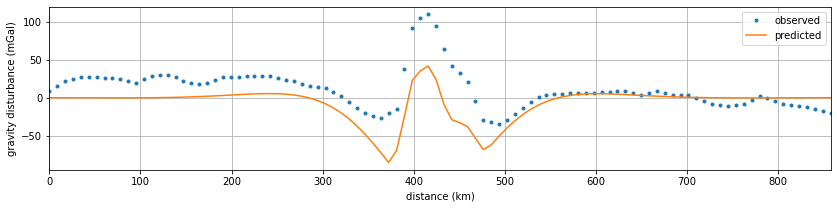

In [16]:
plt.figure(figsize=(14, 3))
plt.plot(profile.distance, profile.gravity_disturbance, ".", label="observed")
plt.plot(profile.distance, predicted_gravity, label="predicted")
plt.legend()
plt.grid()
plt.ylabel("gravity disturbance (mGal)")
plt.xlabel("distance (km)")
plt.xlim(profile.distance.min(), profile.distance.max())

The fit is not great. Our predictions seem to be a bit too small. There are 2 effects that we neglected in our gravity calculations above:

1. The effect of the surface deflection should not be included underneath the seamount
2. The downwards flexure at the surface is not filled with water (look at the bathymetry data). It's actually been packged with sediments.

Let's make a new function that takes these 2 effects into account.

In [17]:
def gravity_seamount_refined(
    deflection, 
    load_height,
    density_sediments, 
    density_crust, 
    density_mantle, 
    density_water,
):
    """
    Model the gravity disturbance caused by a deflection of the lithosphere.
    This refined model removes the effect of the deflection below the seamount
    and accounts for infill of sediments at the surface.
    Inputs are in SI units and outputs are in mGal.    
    """    
    # The gravity of the seamount
    seamount = 2 * np.pi * lithosphere.GRAVITATIONAL_CONSTANT_SI * (density_crust - density_water) * load_height
    # The gravity of the surface deflection
    # Replace the density of water with sediments for the negative deflection
    density_surface = xr.where(deflection > 0, density_crust - density_water, density_sediments - density_crust)
    # Here we remove the effect of the deflection below the seamount by assigning 0 density to it
    density_surface = xr.where(load_height > 0, 0, density_surface)
    surface = 2 * np.pi * lithosphere.GRAVITATIONAL_CONSTANT_SI * density_surface * np.abs(deflection)
    # The gravity of the Moho deflection
    density_moho = xr.where(deflection > 0, density_mantle - density_crust, density_crust - density_mantle)
    moho = 2 * np.pi * lithosphere.GRAVITATIONAL_CONSTANT_SI * density_moho * np.abs(deflection)
    # Combine and convert to mGal
    result = 1e5 * (seamount + surface + moho)
    return result

Recalculate the predicted gravity and plot it along side the data and our previous estimate.

In [18]:
predicted_gravity_refined = gravity_seamount_refined(
    deflection, 
    load_height=load_bathymetry - reference_bathymetry, 
    density_sediments=2000, 
    density_crust=2600, 
    density_water=1000, 
    density_mantle=3300,
)

(0.0, 857.5795528272889)

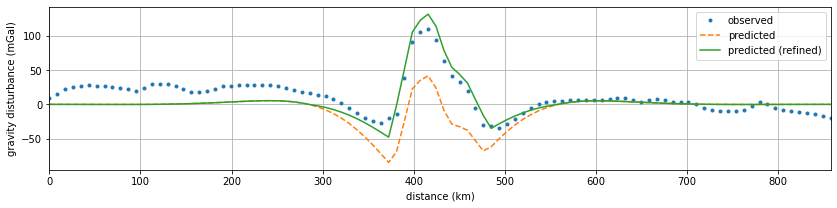

In [19]:
plt.figure(figsize=(14, 3))
plt.plot(profile.distance, profile.gravity_disturbance, ".", label="observed")
plt.plot(profile.distance, predicted_gravity, "--", label="predicted")
plt.plot(profile.distance, predicted_gravity_refined, label="predicted (refined)")
plt.legend()
plt.grid()
plt.ylabel("gravity disturbance (mGal)")
plt.xlabel("distance (km)")
plt.xlim(profile.distance.min(), profile.distance.max())

---

## **Your turn!**

Try out the new modelling tools to investigate a group of seamounts in the Southwest Pacific ocean. The age of the lithosphere is much larger than the example from the Atlantic we just saw (which was next to the mid-ocean ridge). So we expect the lithosphere to be thicker, colder, and denser.

In groups:

1. Extract a profile cutting across one (or more) seamounts
1. Plot the observed gravity and bathymetry along the profile
1. Calculate the deflection caused by the load of the seamount(s)
1. Use the deflection to predict the gravity distubance and compare against observations (you may have to adjust the values of density and effective elastic thickness)
1. Discuss:
    1. What we can learn from these models about seamounts and elastic properties of the oceanic lithosphere
    1. The main limitations of the 1D modelling approach and the approximations we used for the gravity calculations

Share with the class:

1. The plots of your profile data, location, and model predictions 
1. The key discussion points

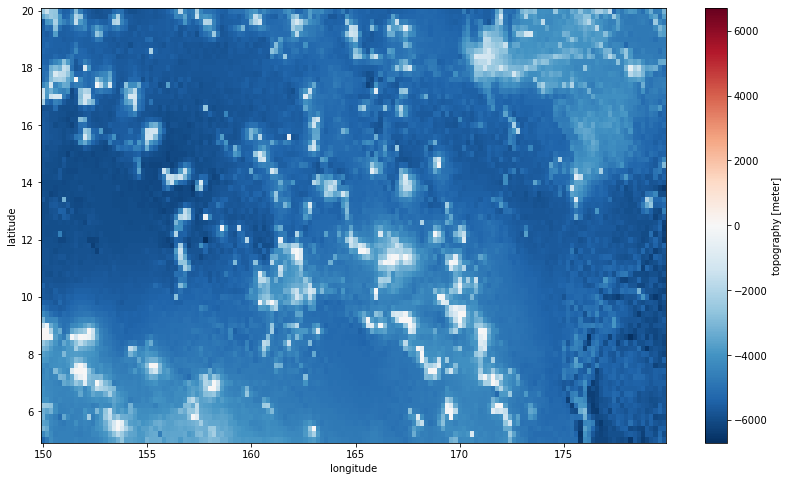

In [20]:
pacific = data.sel(longitude=slice(150, 180), latitude=slice(5, 20))
pacific.topography.plot(figsize=(14, 8))